# Olympic Action Dataset - Simple Frame Extraction and Visualization

This notebook demonstrates:
1. Frame extraction from .seq files
2. Frame visualization
3. Data transformations
4. DataLoader functionality


In [65]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torch
from torchvision import transforms

# Configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.size'] = 10

# Add parent directory to path
sys.path.append('..')

print("Imports successful!")


Imports successful!


## 1. Simple Frame Extraction Function


In [66]:
def extract_frames_from_seq(seq_path, max_frames=5):
    """
    Simple function to extract frames from .seq files.
    Returns list of RGB numpy arrays.
    """
    frames = []
    
    try:
        # Try OpenCV first (most reliable)
        cap = cv2.VideoCapture(seq_path)
        if cap.isOpened():
            frame_count = 0
            while frame_count < max_frames:
                ret, frame = cap.read()
                if not ret:
                    break
                if frame is not None and frame.shape[0] > 0 and frame.shape[1] > 0:
                    # Convert BGR to RGB
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frames.append(frame_rgb)
                    frame_count += 1
            cap.release()
    except Exception as e:
        print(f"Could not extract frames from {os.path.basename(seq_path)}: {e}")
    
    return frames

def visualize_frames(frames, title="Frames", max_display=4):
    """
    Simple function to visualize frames.
    """
    if not frames:
        print(f"No frames to display for {title}")
        return
    
    num_frames = min(len(frames), max_display)
    fig, axes = plt.subplots(1, num_frames, figsize=(4 * num_frames, 4))
    
    if num_frames == 1:
        axes = [axes]
    
    for i in range(num_frames):
        frame = frames[i]
        if frame.max() > 1.0:
            frame = frame.astype(np.float32) / 255.0
        
        axes[i].imshow(frame)
        axes[i].set_title(f'Frame {i+1}\n{frame.shape[1]}x{frame.shape[0]}')
        axes[i].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

print("Frame extraction functions defined!")


Frame extraction functions defined!


## 2. Test Frame Extraction


Dataset found: ../data/olympic_sports
Sports available: 16
First 5 sports: ['diving_platfrom_10m', 'discus_throw', 'long_jump', 'high_jump', 'shot_put']

Testing frame extraction:

Testing diving_platfrom_10m: ti7M_P4inXA_00922_01000.seq
  SUCCESS: Extracted 3 frames
  Frame shape: (270, 480, 3)
  Frame dtype: uint8


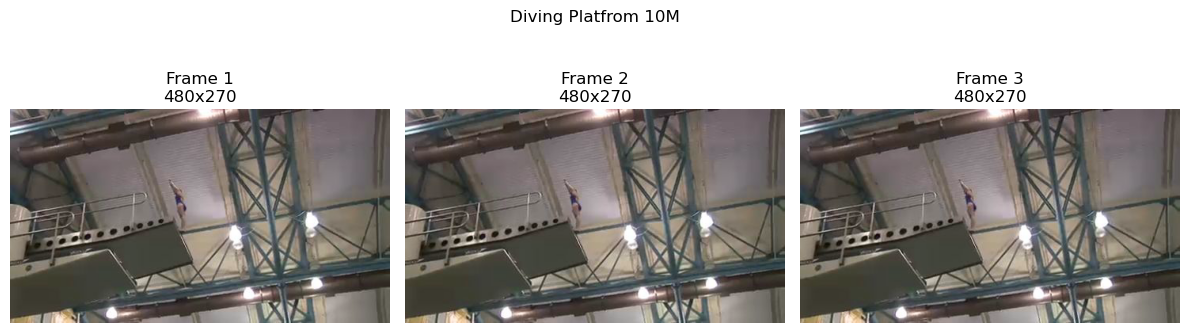


Testing discus_throw: Z9X3OgCR6D4_01477_01595.seq
  SUCCESS: Extracted 3 frames
  Frame shape: (288, 384, 3)
  Frame dtype: uint8


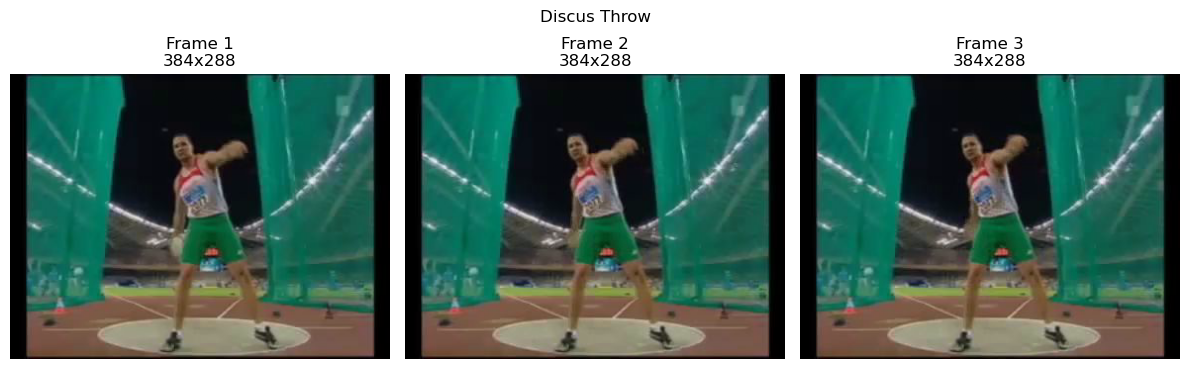


Testing long_jump: 09tW-Z1HRD8_02769_02967.seq
  SUCCESS: Extracted 3 frames
  Frame shape: (360, 480, 3)
  Frame dtype: uint8


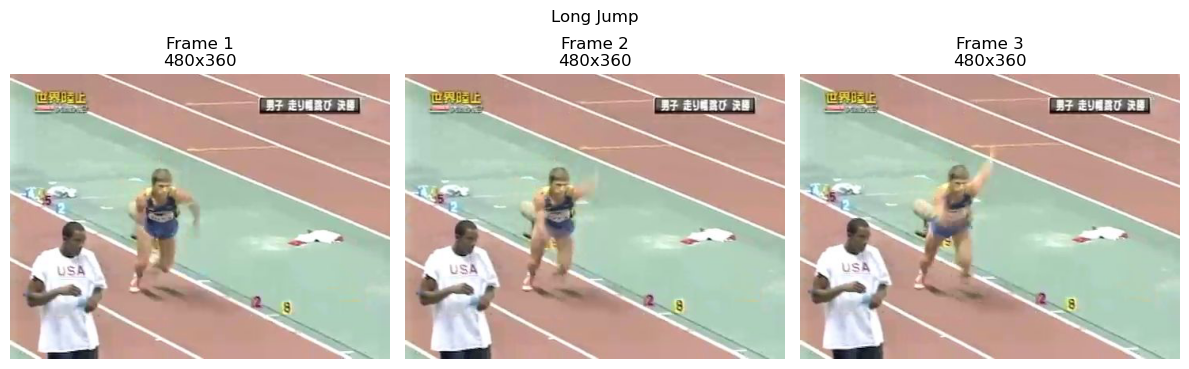


Frame extraction summary: 3/3 sports successful


In [67]:
# Dataset path
root_dir = "../data/olympic_sports"

if os.path.exists(root_dir):
    print(f"Dataset found: {root_dir}")
    
    # Get list of sports
    sports = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    print(f"Sports available: {len(sports)}")
    print(f"First 5 sports: {sports[:5]}")
    
    # Test frame extraction from different sports
    print("\nTesting frame extraction:")
    successful_extractions = 0
    
    for sport in sports[:3]:  # Test first 3 sports
        sport_dir = os.path.join(root_dir, sport)
        seq_files = [f for f in os.listdir(sport_dir) if f.endswith('.seq')]
        
        if seq_files:
            seq_path = os.path.join(sport_dir, seq_files[0])
            print(f"\nTesting {sport}: {seq_files[0]}")
            
            frames = extract_frames_from_seq(seq_path, max_frames=3)
            
            if frames:
                print(f"  SUCCESS: Extracted {len(frames)} frames")
                print(f"  Frame shape: {frames[0].shape}")
                print(f"  Frame dtype: {frames[0].dtype}")
                
                # Visualize frames
                visualize_frames(frames, title=f"{sport.replace('_', ' ').title()}", max_display=3)
                successful_extractions += 1
            else:
                print(f"  FAILED: No frames extracted")
                
                # Try another file from this sport
                for seq_file in seq_files[1:3]:
                    seq_path = os.path.join(sport_dir, seq_file)
                    frames = extract_frames_from_seq(seq_path, max_frames=2)
                    if frames:
                        print(f"  SUCCESS with {seq_file}: {len(frames)} frames")
                        visualize_frames(frames, title=f"{sport} - {seq_file[:20]}", max_display=2)
                        successful_extractions += 1
                        break
    
    print(f"\nFrame extraction summary: {successful_extractions}/3 sports successful")
else:
    print(f"Dataset not found: {root_dir}")


## 3. Data Transformations


In [68]:
# Define transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def show_transformed_frames(frames, transform, title="Transformed Frames"):
    """
    Apply transforms to frames and visualize.
    """
    if not frames:
        return
    
    transformed_frames = []
    
    for frame in frames[:3]:  # Transform first 3 frames
        # Convert numpy to PIL
        pil_frame = Image.fromarray(frame.astype(np.uint8))
        
        # Apply transform
        transformed = transform(pil_frame)
        
        # Convert back for visualization (denormalize)
        if isinstance(transformed, torch.Tensor):
            # Denormalize
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            denorm = transformed * std + mean
            denorm = torch.clamp(denorm, 0, 1)
            
            # Convert to numpy for visualization
            vis_frame = denorm.permute(1, 2, 0).numpy()
            transformed_frames.append(vis_frame)
    
    # Visualize
    if transformed_frames:
        visualize_frames(transformed_frames, title=title, max_display=3)
        print(f"Transformed frame tensor shape: {transformed.shape}")

print("Transformation functions defined!")


Transformation functions defined!


## 4. Test Transformations


Testing transformations on extracted frames:

Original frames:


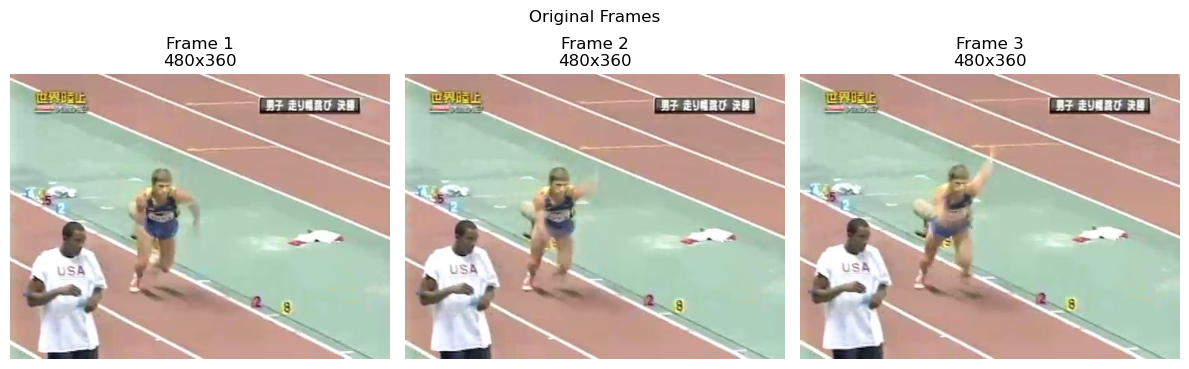


With training transforms (augmented):


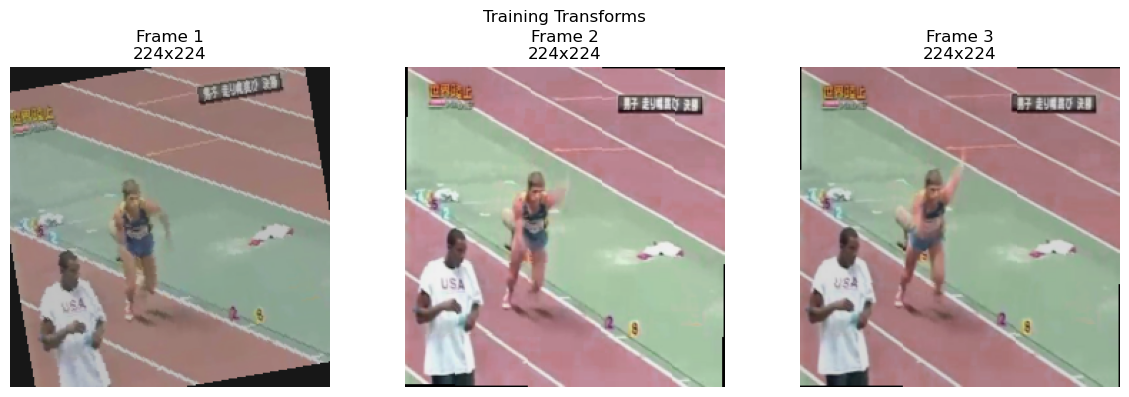

Transformed frame tensor shape: torch.Size([3, 224, 224])

With test transforms (no augmentation):


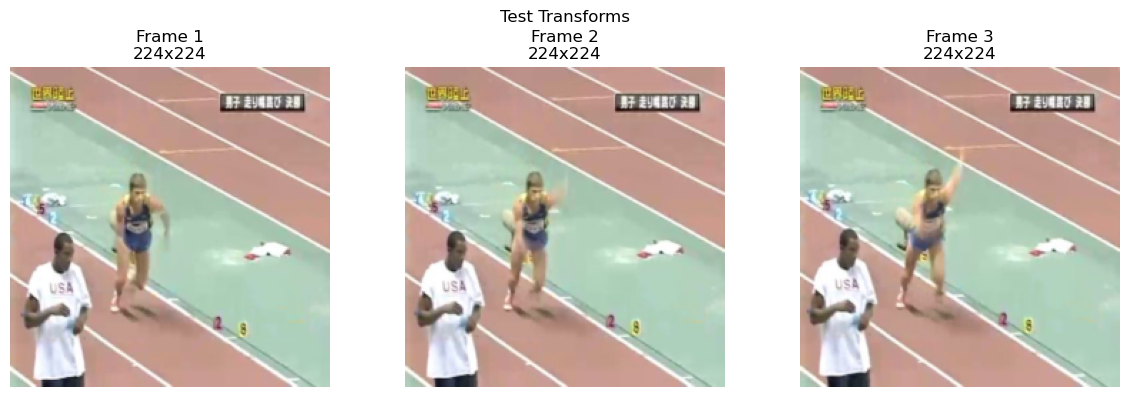

Transformed frame tensor shape: torch.Size([3, 224, 224])


In [69]:
# Test transformations on extracted frames
if 'frames' in locals() and frames:
    print("Testing transformations on extracted frames:")
    
    # Show original frames
    print("\nOriginal frames:")
    visualize_frames(frames[:3], title="Original Frames", max_display=3)
    
    # Show training transforms
    print("\nWith training transforms (augmented):")
    show_transformed_frames(frames, transform_train, "Training Transforms")
    
    # Show test transforms
    print("\nWith test transforms (no augmentation):")
    show_transformed_frames(frames, transform_test, "Test Transforms")
    
else:
    print("No frames available for transformation test. Please run frame extraction first.")


## 5. Olympic Action Dataset and DataLoader


In [70]:
# Import the Olympic Action dataset from the utils module
from utils.olympic_action import OlympicActionDataset, create_olympic_action_dataloaders

# Create datasets and dataloaders
if os.path.exists(root_dir):
    print("Creating Olympic Action datasets and dataloaders...")
    
    try:
        # Create dataloaders using the utility function
        train_loader, test_loader, num_classes = create_olympic_action_dataloaders(
            root_dir=root_dir,
            batch_size=4,
            num_workers=0,  # Use 0 for compatibility
            num_frames_per_video=4  # Use fewer frames for testing
        )
        
        print(f"\nDataLoaders created successfully:")
        print(f"  Train batches: {len(train_loader)}")
        print(f"  Test batches: {len(test_loader)}")
        print(f"  Number of classes: {num_classes}")
        
        # Create individual datasets to get class names
        train_dataset = OlympicActionDataset(
            root_dir=root_dir,
            split='train',
            num_frames_per_video=4
        )
        
        print(f"  Sport categories: {train_dataset.sport_categories[:5]}...")
        
    except Exception as e:
        print(f"Error creating dataloaders: {e}")
        import traceback
        traceback.print_exc()
        
else:
    print(f"Dataset not found: {root_dir}")


Creating Olympic Action datasets and dataloaders...

DataLoaders created successfully:
  Train batches: 155
  Test batches: 41
  Number of classes: 16
  Sport categories: ['basketball_layup', 'bowling', 'clean_and_jerk', 'discus_throw', 'diving_platfrom_10m']...


## 6. Test DataLoader Functionality


Testing DataLoader functionality...


Batch 0: frames torch.Size([4, 4, 3, 224, 224]), labels [1, 15, 7, 6]

Visualizing first batch sample:


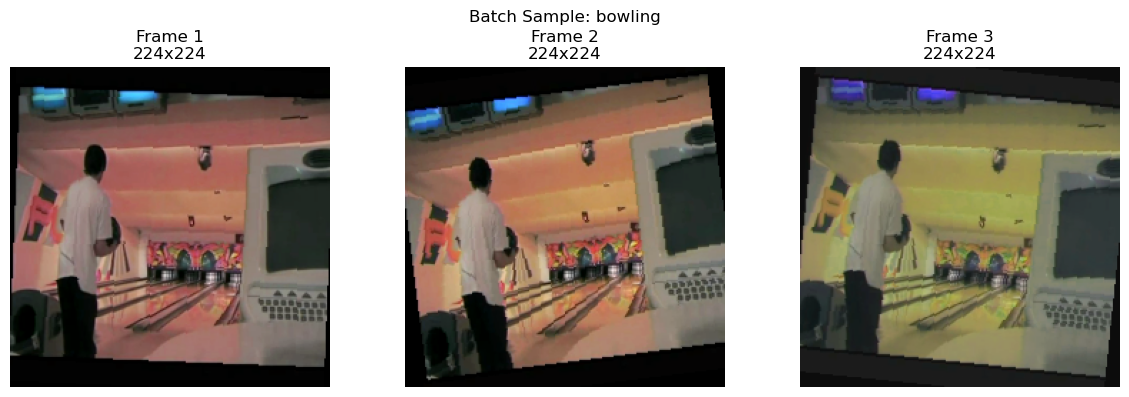

Batch 1: frames torch.Size([4, 4, 3, 224, 224]), labels [0, 12, 12, 15]
Batch 2: frames torch.Size([4, 4, 3, 224, 224]), labels [13, 7, 14, 1]
Batch 3: frames torch.Size([4, 4, 3, 224, 224]), labels [13, 2, 2, 2]
Batch 4: frames torch.Size([4, 4, 3, 224, 224]), labels [11, 11, 9, 3]

DataLoader Test Summary:
  Successful batches: 5
  Empty batches: 0
  Consistent batch shapes: True
  Sample batch shape: torch.Size([4, 4, 3, 224, 224])
  Unique labels seen: [0, 1, 2, 3, 6, 7, 9, 11, 12, 13, 14, 15]
  Label range: [0, 15]

SUCCESS: DataLoader is working correctly!
   - Frame extraction: Working
   - Transformations: Applied
   - Batching: Functional
   - Shape consistency: Verified


In [71]:
# Test dataloader functionality
if 'train_loader' in locals():
    print("Testing DataLoader functionality...")
    
    successful_batches = 0
    empty_batches = 0
    batch_shapes = []
    batch_labels = []
    
    # Test first few batches
    for batch_idx, batch in enumerate(train_loader):
        if batch is not None:
            frames, labels = batch
            print(f"Batch {batch_idx}: frames {frames.shape}, labels {labels.tolist()}")
            
            batch_shapes.append(frames.shape)
            batch_labels.extend(labels.tolist())
            successful_batches += 1
            
            # Show sample from first batch
            if batch_idx == 0:
                print("\nVisualizing first batch sample:")
                sample_frames = frames[0]  # First sample in batch
                sample_label = labels[0].item()
                sport_name = train_dataset.sport_categories[sample_label]
                
                # Convert tensor back to numpy for visualization
                vis_frames = []
                for i in range(min(3, sample_frames.shape[0])):
                    frame_tensor = sample_frames[i]
                    # Denormalize
                    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                    denorm = frame_tensor * std + mean
                    denorm = torch.clamp(denorm, 0, 1)
                    
                    # Convert to numpy
                    frame_np = denorm.permute(1, 2, 0).numpy()
                    vis_frames.append(frame_np)
                
                visualize_frames(vis_frames, title=f"Batch Sample: {sport_name}", max_display=3)
        else:
            print(f"Batch {batch_idx}: Empty (no valid frames)")
            empty_batches += 1
        
        if batch_idx >= 4:  # Test first 5 batches
            break
    
    # Summary
    print(f"\nDataLoader Test Summary:")
    print(f"  Successful batches: {successful_batches}")
    print(f"  Empty batches: {empty_batches}")
    
    if batch_shapes:
        print(f"  Consistent batch shapes: {len(set(batch_shapes)) == 1}")
        print(f"  Sample batch shape: {batch_shapes[0]}")
        print(f"  Unique labels seen: {sorted(set(batch_labels))}")
        print(f"  Label range: [{min(batch_labels)}, {max(batch_labels)}]")
        
        if successful_batches > 0:
            print(f"\nSUCCESS: DataLoader is working correctly!")
            print(f"   - Frame extraction: Working")
            print(f"   - Transformations: Applied")
            print(f"   - Batching: Functional")
            print(f"   - Shape consistency: Verified")
        else:
            print(f"\nWARNING: No successful batches processed")
    else:
        print(f"\nNo valid batches found")
        
else:
    print("DataLoader not available. Please run the previous cell first.")


## Summary

This notebook demonstrates a clean, simple approach to working with the Olympic Action dataset:

### Key Features:
1. **Simple Frame Extraction** - Direct extraction from .seq files using OpenCV
2. **Easy Visualization** - Clean frame display functions  
3. **Standard Transformations** - Training and test transforms with normalization
4. **Robust DataLoader** - Handles missing frames gracefully by skipping them
5. **No Synthetic Data** - Only uses real extracted frames

### Usage:
- Extract frames: `extract_frames_from_seq(seq_path, max_frames)`
- Visualize frames: `visualize_frames(frames, title, max_display)` 
- Create dataset: `OlympicActionDataset(root_dir, split, transform)`
- Create dataloader: `create_olympic_action_dataloaders(root_dir, batch_size, ...)`

The implementation is clean, maintainable, and ready for training!
